In [35]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

### Plot the top 10 tags for 2022 and look at their corresponding popularity in 2023

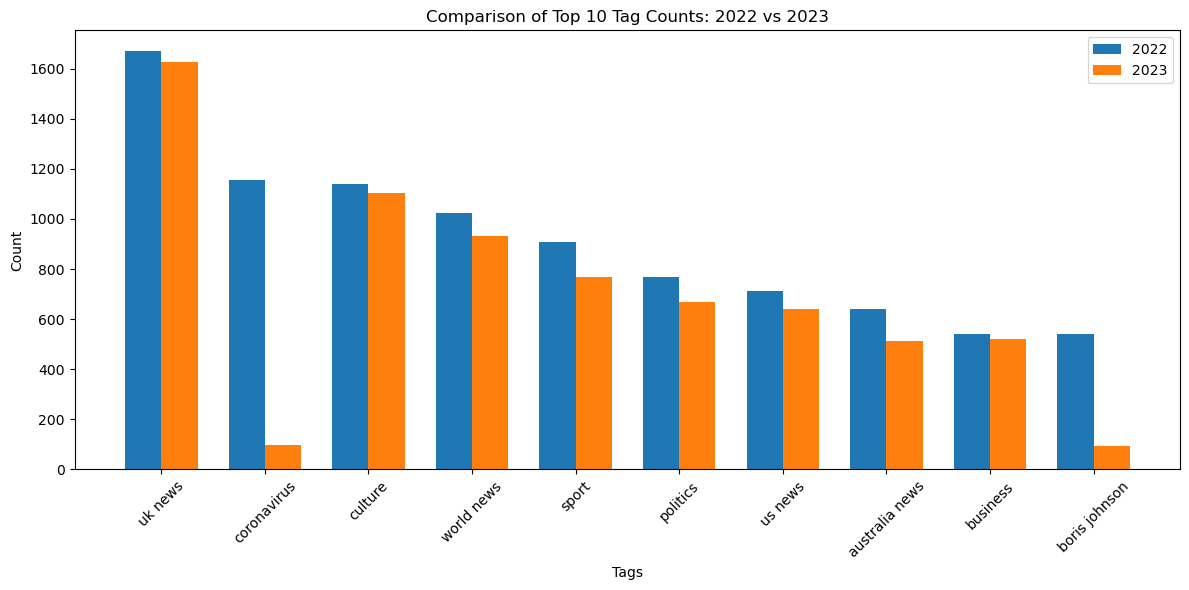

In [39]:


# Load 2022 data
df_articles_2022 = pd.read_csv('../../data/processed/articles/2022_articles_processed.csv', sep=';')
df_articles_2022['Tags'] = df_articles_2022['Tags'].str.lower()
df_articles_2022['Tags'] = df_articles_2022['Tags'].apply(ast.literal_eval)

# Get tag counts for 2022
all_tags_2022 = [tag for tags in df_articles_2022['Tags'] for tag in tags]
tag_counts_2022 = Counter(all_tags_2022)
df_tag_counts_2022 = pd.DataFrame.from_dict(tag_counts_2022, orient='index', columns=['Count']).reset_index()
df_tag_counts_2022 = df_tag_counts_2022.rename(columns={'index': 'Tag'})
df_tag_counts_2022 = df_tag_counts_2022.sort_values(by='Count', ascending=False)
top_10_2022 = df_tag_counts_2022.head(10)

# Load 2023 data
df_articles_2023 = pd.read_csv('../../data/processed/articles/2023_articles_processed.csv', sep=';')
df_articles_2023['Tags'] = df_articles_2023['Tags'].str.lower()
df_articles_2023['Tags'] = df_articles_2023['Tags'].apply(ast.literal_eval)

# Get tag counts for 2023 for the same top tags of 2022
tag_counts_2023 = Counter([tag for tags in df_articles_2023['Tags'] for tag in tags if tag in top_10_2022['Tag'].values])
df_tag_counts_2023 = pd.DataFrame.from_dict(tag_counts_2023, orient='index', columns=['Count']).reset_index()
df_tag_counts_2023 = df_tag_counts_2023.rename(columns={'index': 'Tag'})
df_tag_counts_2023 = df_tag_counts_2023.sort_values(by='Count', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))

bar_width = 0.35  # Width of the bars
index = range(len(top_10_2022))

# Plot for 2022
plt.bar(index, top_10_2022['Count'], bar_width, alpha=1, label='2022')

# Plot for 2023 (using adjusted x-axis positions)
counts_2023_mapped = [tag_counts_2023.get(tag, 0) for tag in top_10_2022['Tag']]
plt.bar([i + bar_width for i in index], counts_2023_mapped, bar_width, alpha=1, label='2023')

plt.title('Comparison of Top 10 Tag Counts: 2022 vs 2023')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.xticks([i + bar_width / 2 for i in index], top_10_2022['Tag'], rotation=45)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

### Plot the popularity of different categories over time

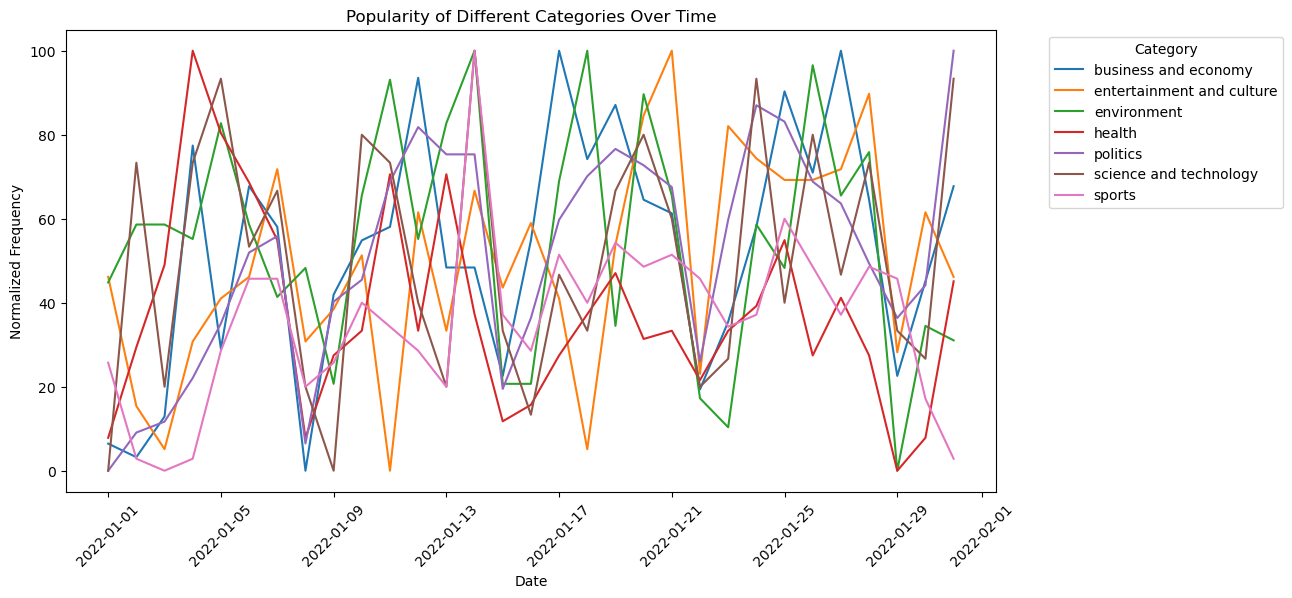

In [3]:
# Load the CSV file
df = pd.read_csv('../../data/processed/articles/2022_articles_processed.csv', sep=';')

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Group by 'Date' and 'Category' and calculate the frequency for each category on each date
df_category_freq = df.groupby(['Date', 'Category']).size().reset_index(name='Frequency')

# Normalize the frequency values for each category on a scale from 0-100
def min_max_scaling(x):
    return ((x - x.min()) / (x.max() - x.min())) * 100

df_category_freq['Frequency_normalized'] = df_category_freq.groupby('Category')['Frequency'].transform(min_max_scaling)

# Plotting the data for each category

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_category_freq, x='Date', y='Frequency_normalized', hue='Category')
plt.title('Popularity of Different Categories Over Time')
plt.ylabel('Normalized Frequency')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Calculate the pearson correlation with lag 0, 1 and 2 

In [40]:
# Load the CSV file
df = pd.read_csv('../../data/processed/articles/2023_articles_processed.csv', sep=';')

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

unique_categories = df['Category'].unique()

correlation_data = []

for category in unique_categories:
    df_categorized = df[df['Category'] == category]
    df_score = df_categorized.groupby(df_categorized['Date'])['Average Score'].mean().reset_index()
    df_freq = df_categorized.groupby(df_categorized['Date']).size().reset_index(name='Frequency')
    
    # normalize the values for avg_score and frequency on a scale from 0-100
    def min_max_scaling(x, min_val, max_val):
        return ((x - min_val) / (max_val - min_val)) * 100
    
    frequency_column = 'Frequency'
    avg_column = "Average Score"
    
    df_freq[frequency_column + '_normalized'] = min_max_scaling(df_freq[frequency_column], df_freq[frequency_column].min(), df_freq[frequency_column].max())
    df_score[avg_column + '_normalized'] = min_max_scaling(df_score[avg_column], df_score[avg_column].min(), df_score[avg_column].max())

    merged_df = pd.merge(df_score, df_freq, on='Date')
    
    for lag in range(0, 3):  # set lag values
        merged_df['Frequency_normalized_shifted'] = merged_df['Frequency_normalized'].shift(lag)
        
        # Drop rows with NaN values after shifting
        merged_df.dropna(subset=['Frequency_normalized_shifted'], inplace=True)
        
        # Calculate delayed correlation if enough data points are available
        if len(merged_df) > 1:  # Ensure enough non-null data points for correlation calculation
            correlation_delayed = merged_df['Average Score_normalized'].corr(merged_df['Frequency_normalized_shifted'])
            correlation_data.append({'Category': category, 'Lag': lag, 'Correlation': correlation_delayed})
        else:
            correlation_data.append({'Category': category, 'Lag': lag, 'Correlation': None})

correlation_df = pd.DataFrame(correlation_data)

### Plot the relationship between frequency of published articles and popularity of the corresponding category

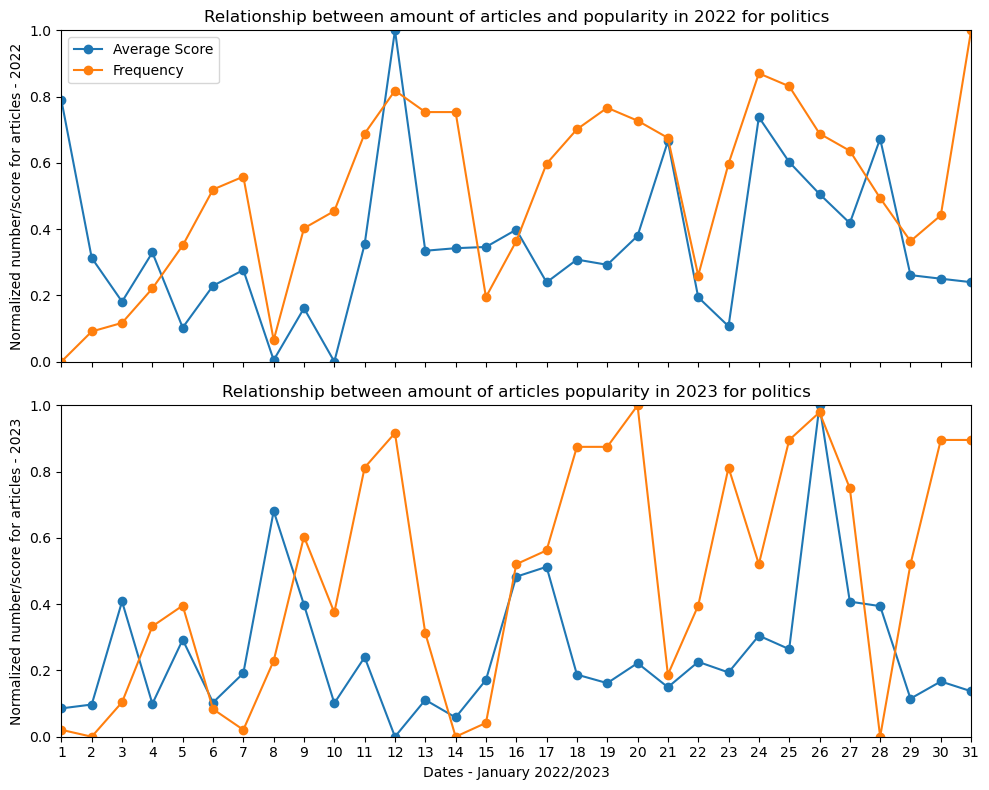

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files for 2022 and 2023 (assuming you've loaded the data already)

# ... (Assume you have loaded and processed the data as in your provided code)

# Plotting for each year separately
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 2022 data with markers for each day
axs[0].plot(df_score_2022.index, df_score_2022['Average Score_normalized'] / 100, label='Average Score', marker='o')
axs[0].plot(df_freq_2022.index, df_freq_2022['Frequency_normalized'] / 100, label='Frequency', marker='o')
axs[0].set_ylabel("Normalized number/score for articles - 2022")
axs[0].set_title("Relationship between amount of articles and popularity in 2022 for " + category)
axs[0].legend()

# Set x-tick labels as indicators for days
days_2022 = df_score_2022['Date'].apply(lambda x: int(x.split('-')[1])).tolist()
axs[0].set_xticks(df_score_2022.index)
axs[0].set_xticklabels(days_2022)

# Adjust x-axis limits to remove extra space
axs[0].set_xlim([df_score_2022.index.min(), df_score_2022.index.max()])

# Set y-axis limits to display a range between 0 and 1
axs[0].set_ylim(0, 1)

# Plot 2023 data with markers for each day
axs[1].plot(df_score_2023.index, df_score_2023['Average Score_normalized'] / 100, label='Average Score - 2023', marker='o')
axs[1].plot(df_freq_2023.index, df_freq_2023['Frequency_normalized'] / 100, label='Frequency - 2023', marker='o')
axs[1].set_ylabel("Normalized number/score for articles - 2023")
axs[1].set_title("Relationship between amount of articles popularity in 2023 for " + category)

# Set x-tick labels as indicators for days
days_2023 = df_score_2023['Date'].apply(lambda x: int(x.split('-')[1])).tolist()
axs[1].set_xticks(df_score_2023.index)
axs[1].set_xticklabels(days_2023)

# Adjust x-axis limits to remove extra space
axs[1].set_xlim([df_score_2023.index.min(), df_score_2023.index.max()])

# Set y-axis limits to display a range between 0 and 1
axs[1].set_ylim(0, 1)
axs[1].set_xlabel(f"Dates - January 2022/2023")
plt.tight_layout()
plt.show()